In [49]:
import os
import random
import re

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, HashingVectorizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import RidgeClassifier
#from sklearn.linear_model import SGDlassifier(loss = ...)

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Summary

* Build and test a simple preprocessing pipe that handles *LaTeX* formulas prepended to count-vectorization and TFIDF transformation.
* Test a handful of shallow multiclass classifiers with *macro-F1* as the objective (in a noninteractive fashion)
* Plot the scores

---

## Define the measure of success

In [32]:
# available scores
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [5]:
scoring = "f1_macro"
average = "macro"

## Read in the two-column data frame (text + labels)

In [ ]:
file = os.path.join("data", "bare_all.csv")

data = pd.read_csv(file, delimiter='\t')

In [8]:
# take 20k records to play with
small_num = 20000
sample = data[:small_num]

text = sample.text
label = sample.label

## Have a look at the data

In [9]:
print(f"No all records in memory: {round(len(data)/1000)}'000")
with pd.option_context('display.max_colwidth', 120):
    display(data[:3])

No all records in memory: 837'000


,text,label
0,Power sum decompositions of defining equations of reflection arrangements. We determine the Waring rank of the fund...,math
1,A Spectroscopic Survey of Massive Stars in M31 and M33. We describe our spectroscopic follow-up to the Local Group ...,phys
2,Hamiltonian Thermodynamics of Black Holes in Generic 2-D Dilaton Gravity. We consider the Hamiltonian mechanics and...,phys


Abstracts of scientific papers tend to be written in a formal style, to not contain typos, nor direct citations, little references, ...

In [10]:
for _ in range(2):
    print(text.iloc[random.choice(range(len(text)))])
    print("---")

A Modular Formalization of Reversibility for Concurrent Models and Languages.  Causal-consistent reversibility is the reference notion of reversibility for concurrency. We introduce a modular framework for defining causal-consistent reversible extensions of concurrent models and languages. We show how our framework can be used to define reversible extensions of formalisms as different as CCS and concurrent X-machines. The generality of the approach allows for the reuse of theories and techniques in different settings. 
---
Modular circle quotients and PL limit sets.  We say that a collection Gamma of geodesics in the hyperbolic plane H^2 is a modular pattern if Gamma is invariant under the modular group PSL_2(Z), if there are only finitely many PSL_2(Z)-equivalence classes of geodesics in Gamma, and if each geodesic in Gamma is stabilized by an infinite order subgroup of PSL_2(Z). For instance, any finite union of closed geodesics on the modular orbifold H^2/PSL_2(Z) lifts to a modular

### One messy but informative kind of writing they have are LaTeX formulas (*\$...\$*)

In [11]:
text[9]

'Distribution of the roots of the equations $Z(t)=0$, $Z\'(t)=0$ in the theory of the Riemann zeta-function.  Let the symbols $\\{\\gamma\\},\\ \\{t_0\\};\\ t_0\\not=\\gamma$ denote the sequences of the roots of the equations $$Z(t)=0,\\quad \\text{and}\\qquad Z\'(t)=0,$$ respectively, and $$m(t_0)=\\min\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad Q(t_0)=\\max\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad \\gamma\'<t_0<\\gamma",$$ where $\\gamma\',\\gamma"$ are the neighboring zeroes. We have proved the following in this paper: on the Riemann hypothesis we have $$\\frac{Q(t_0)}{m(t_0)}<t_0\\ln^2t_0\\ln_2t_0\\ln_3t_0,\\quad t_0\\to\\infty.$$ This paper is the English version of the paper of ref. \\cite{5}. '

### We choose to either mask them with * \_latex\_ * or flag them by appending * \_latex\_ * in front of each such expression. 

In [12]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace r"(\${1,2}[...]*?\${1,2})" with ' _latex_ ' or 'latex \1'
    """
    # why does it differ from  r'(\$.+?\$)' ?
    
    def __init__(self, behave = 'flag'):
        self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
        if behave:
            self.repl = ' _LATEX_ ' if behave == 'mask' else  r' _LATEX_ \1'
        else:
            self.repl = r'\1' # do nothing with extra steps
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(self.pattern, self.repl)
            

In [13]:
delatex = DeLaTeX(behave = None)
delatex.transform(text[9:10])[9]

'Distribution of the roots of the equations $Z(t)=0$, $Z\'(t)=0$ in the theory of the Riemann zeta-function.  Let the symbols $\\{\\gamma\\},\\ \\{t_0\\};\\ t_0\\not=\\gamma$ denote the sequences of the roots of the equations $$Z(t)=0,\\quad \\text{and}\\qquad Z\'(t)=0,$$ respectively, and $$m(t_0)=\\min\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad Q(t_0)=\\max\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad \\gamma\'<t_0<\\gamma",$$ where $\\gamma\',\\gamma"$ are the neighboring zeroes. We have proved the following in this paper: on the Riemann hypothesis we have $$\\frac{Q(t_0)}{m(t_0)}<t_0\\ln^2t_0\\ln_2t_0\\ln_3t_0,\\quad t_0\\to\\infty.$$ This paper is the English version of the paper of ref. \\cite{5}. '

In [14]:
delatex = DeLaTeX(behave = 'mask')
delatex.transform(text[9:10])[9]

'Distribution of the roots of the equations  _LATEX_ ,  _LATEX_  in the theory of the Riemann zeta-function.  Let the symbols  _LATEX_  denote the sequences of the roots of the equations  _LATEX_  respectively, and  _LATEX_  where  _LATEX_  are the neighboring zeroes. We have proved the following in this paper: on the Riemann hypothesis we have  _LATEX_  This paper is the English version of the paper of ref. \\cite{5}. '

In [15]:
delatex = DeLaTeX(behave = 'flag')
delatex.transform(text[9:10])[9]

'Distribution of the roots of the equations  _LATEX_ $Z(t)=0$,  _LATEX_ $Z\'(t)=0$ in the theory of the Riemann zeta-function.  Let the symbols  _LATEX_ $\\{\\gamma\\},\\ \\{t_0\\};\\ t_0\\not=\\gamma$ denote the sequences of the roots of the equations  _LATEX_ $$Z(t)=0,\\quad \\text{and}\\qquad Z\'(t)=0,$$ respectively, and  _LATEX_ $$m(t_0)=\\min\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad Q(t_0)=\\max\\{\\gamma"-t_0,t_0-\\gamma\'\\},\\quad \\gamma\'<t_0<\\gamma",$$ where  _LATEX_ $\\gamma\',\\gamma"$ are the neighboring zeroes. We have proved the following in this paper: on the Riemann hypothesis we have  _LATEX_ $$\\frac{Q(t_0)}{m(t_0)}<t_0\\ln^2t_0\\ln_2t_0\\ln_3t_0,\\quad t_0\\to\\infty.$$ This paper is the English version of the paper of ref. \\cite{5}. '

## Encode the labels

In [16]:
# 'cs' -> 0, ..., 'stat' -> 5

label_e = LabelEncoder()
y_train = label_e.fit_transform(label)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat']


## Optionally, have a look at the most frequent words.

In [17]:
delatex = DeLaTeX(behave = 'flag')
count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(delatex.fit_transform(text))

In [18]:
sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(round(sum_word_counts_train[0, i],-3), word) for word, i in count_v.vocabulary_.items()],reverse=True)[:10]

[(213000, 'the'),
 (135000, 'of'),
 (75000, 'and'),
 (67000, 'in'),
 (56000, 'to'),
 (43000, 'we'),
 (40000, 'is'),
 (36000, 'for'),
 (36000, '_latex_'),
 (29000, 'that')]

---

## Go step by step through an arbitrary pipeline 

In [19]:
text_train = text

In [20]:
delatex = DeLaTeX()
tex_text_train = delatex.fit_transform(text_train)

In [21]:
tfidf_v = TfidfVectorizer(use_idf=True, min_df = 2, max_df=0.8, strip_accents='unicode')
tfidf_scores_train = tfidf_v.fit_transform(tex_text_train)

In [22]:
lsvc = LinearSVC(C=1, class_weight='balanced')
lsvc.fit(tfidf_scores_train, y_train)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Ok, let's just have some fun first:

In [23]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms. This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
novel intuitive proof of $\limit_{x\to 0} x = 0$ convergence fomula,
""",
"""
inflation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])

label_e.inverse_transform(lsvc.predict(tfidf_v.transform(delatex.transform(random_abstracts ))))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

Looks promising :)
Here's the actual score on a test set:

In [24]:
text_test = data[small_num:2*small_num].text
y_test = label_e.transform(data[small_num:2*small_num].label)

In [25]:
predicted_y_test = lsvc.predict(tfidf_v.transform(delatex.transform(text_test)))

In [26]:
print("Macro F1:", f1_score(y_test, predicted_y_test, average="macro"))
print(classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
print(confusion_matrix(y_test, predicted_y_test))

Macro F1: 0.749729642271259
              precision    recall  f1-score   support

          cs       0.82      0.87      0.84      2656
        math       0.85      0.88      0.87      4465
        phys       0.97      0.95      0.96     12194
       q-bio       0.59      0.52      0.55       231
       q-fin       0.81      0.69      0.75       110
        stat       0.54      0.51      0.53       344

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.76      0.74      0.75     20000
weighted avg       0.91      0.91      0.91     20000

[[ 2301   231    60    13     6    45]
 [  211  3944   225    13     7    65]
 [  166   353 11602    48     3    22]
 [   35    17    45   120     0    14]
 [    9    14     8     0    76     3]
 [   86    55    15     9     2   177]]


"By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$." https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Having trained on 20k records with an untuned Linear SVM, we have reached 0.75 macro-F1 (out of sample) pulled down by poor performomance on classification wrt rarer classes. E.g. many *cs* and *math* are confused with *stat* (and vice versa), and similarly for *q-bio* and *physics*. This is actually sensible.

---

## Grid search with CV by hand

In [275]:
pipe = []
pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=False, strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
pipe.append(( 'LinearSVC', LinearSVC(C=1, penalty='l2', class_weight='balanced')  ))

In [276]:
params = {
    'delatex__behave': ['mask', None],
    'tfidf_v__ngram_range': [(1, 1),(1,2)],
    'tfidf_v__use_idf': [False, True],
    'tfidf_v__max_df': [0.7, 0.9],
}
params['LinearSVC' + '__' + 'C'] = [0.1, 1]
params

{'delatex__behave': ['mask', None],
 'tfidf_v__ngram_range': [(1, 1), (1, 2)],
 'tfidf_v__use_idf': [False, True],
 'tfidf_v__max_df': [0.7, 0.9],
 'LinearSVC__C': [0.1, 1]}

In [277]:
# LONG WAIT

# there's some bug with njobs different than 1 because of the delatex in the pipe

grid_s = GridSearchCV(Pipeline(pipe), params, cv=5, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False)
grid_s.fit(text_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave=None)), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2'...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'delatex__behave': ['mask', None], 'tfidf_v__ngram_range': [(1, 1), (1, 2)], 'tfidf_v__use_idf': [False, True], 'tfidf_v__max_df': [0.7, 0.9], 'LinearSVC__C': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [278]:
grid_s.best_params_

{'LinearSVC__C': 0.1,
 'delatex__behave': 'mask',
 'tfidf_v__max_df': 0.7,
 'tfidf_v__ngram_range': (1, 1),
 'tfidf_v__use_idf': True}

In [279]:
results = pd.DataFrame(grid_s.cv_results_)
cols = ['param_' + param for param in params.keys()] + ['mean_test_score']

results[cols].sort_values(by=['param_LinearSVC__C','mean_test_score'], ascending=False)

,param_delatex__behave,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
17,mask,"(1, 1)",True,0.7,1,0.753318
25,None,"(1, 1)",True,0.7,1,0.753318
21,mask,"(1, 1)",True,0.9,1,0.751887
29,None,"(1, 1)",True,0.9,1,0.751887
20,mask,"(1, 1)",False,0.9,1,0.744601
28,None,"(1, 1)",False,0.9,1,0.744601
16,mask,"(1, 1)",False,0.7,1,0.737964
24,None,"(1, 1)",False,0.7,1,0.737964
19,mask,"(1, 2)",True,0.7,1,0.736053
27,None,"(1, 2)",True,0.7,1,0.736053


With regards to our preprocessing steps:
    * our DeLaTeX does not help at all
    * it is better to use IDF
    * max_df=0.7 is slightly better than 0.9
    * using 1-grams alone in the count-vectorizer proved to be no visibly better than adding *2grams*
   
### We will stick to those settings in tuning the classifiers' hyperparameters below.

---

## Automated GridSearchCV for multiple classifiers

### helper functions

In [27]:
def build_clf(name, model):
    pipe = []
    #pipe.append(( 'delatex', DeLaTeX(behave='flag') ))
    pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=True, strip_accents='unicode', min_df = 2, max_df = 0.7)  ))
    pipe.append(( name, model  ))
    
    return Pipeline(pipe)

In [28]:
def build_pipe_params(name, model_params):
    params = {
        #'delatex__behave': [None],
        'tfidf_v__ngram_range': [(1, 1)],
        'tfidf_v__use_idf': [True],
        'tfidf_v__max_df': [0.7],
    }
    for (param_name, range_) in model_params:
        params[name + '__' + param_name] = range_
        
    return params

### Specify models with grid of parametrs and run the GridSearchCV, cv=5 (stratified by default)

In [33]:
models = {
    'LinearSVC': [LinearSVC(class_weight='balanced'),
                  [( 'C', [1] )]
                 ],
    'LogisticR': [LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='ovr'),
                  [( 'C', [1] )]
                 ],
    'RandomFC': [RandomForestClassifier(class_weight='balanced', n_estimators=100, ),
                 [('max_depth', [20]) , ('min_samples_leaf', [10])]
                ],
    'MulinomNB': [MultinomialNB(),
                [('alpha', [1]), ('fit_prior', [True])]
               ]
}

In [35]:
# GRID-SEARCH

# collect the best_params for the models
results = {}

for name, (model, model_params) in models.items():
    
    print(name)
    pipe = build_clf(name, model)
    params = build_pipe_params(name, model_params)
    
    grid_s = GridSearchCV(pipe, params, cv=5, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False)
    grid_s.fit(text_train, y_train)
    
    print(grid_s.best_score_, "\n")
    results[name] = [grid_s.best_params_, grid_s.best_score_, grid_s.cv_results_]

    
# store the best_params in the models dict
for name, result in results.items():
    
    best_params = result[0]    
    print(name, best_params)
    models[name][1] = best_params

LinearSVC
0.7533176359424341 

LogisticR
0.7461565618083735 

RandomFC
0.6563406624672407 

MulinomNB


C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\c

0.4254312712328293 



### Fit the whole train data to the tuned classifiers. Record final scores on test data.

In [43]:
large_num = 30_000
train_vol = int(large_num*4/5)

final_train = data[:train_vol]
final_test = data[train_vol:large_num]


final_text_train = final_train.text
final_y_train = label_e.transform(final_train.label)

final_text_test = final_test.text
final_y_test = label_e.transform(final_test.label)

In [45]:
final_scores = {}

for name, (model, pipe_best_params) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**pipe_best_params)
    clf.fit(final_text_train, final_y_train)
    
    final_scores[name] = f1_score(final_y_test, clf.predict(final_text_test), average='macro')

C:\Users\olspa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
final_scores

{'LinearSVC': 0.7499445806947218,
 'LogisticR': 0.7695364539630752,
 'RandomFC': 0.6634326117503377,
 'MulinomNB': 0.4250664956892689}

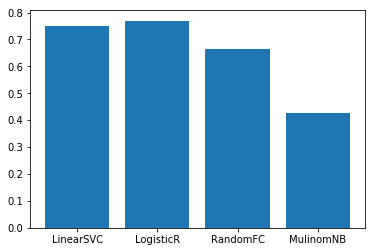

In [48]:
count = range(len(final_scores))
plt.bar(count, list(final_scores.values()))
plt.xticks(count, list(final_scores.keys()))
plt.show()